# Retroperitoneal sarcoma radiomics study
# Prediction of tumour type and grade
# Logistic regression with group selection

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500, 'display.max_rows', 500, 'display.precision', 3)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_validate
import os, warnings, copy, sys
import matplotlib.pyplot as plt
import dill
import pickle

rootFolder = os.path.join(os.path.expanduser("~"), 'Dicom Files/RADSARC_R')

# this module should be in the same folder as this notebook
from fit_LR_groupSelection_correlationThresholds import fit_LR_groupSelection_correlationThresholds, displayResultExperiments, displayOneExperiment


### Utility functions

In [2]:
def groupStrsDisp(strGroups):
    
    def tidyGroup(strGroup):
        if strGroup == '':
            strGroup = 'all'
        strGroup = strGroup.replace('glcm|gldm|glszm|glrlm|ngtdm','texture')
        strGroup = strGroup.replace('firstorder|histogram','firstorder')
        return strGroup

    if isinstance(strGroups, str):
        return tidyGroup(strGroups)
    
    if isinstance(strGroups, list):
        return [tidyGroup(x) for x in strGroups]

## Load data

In [3]:
# open clinical spreadsheet
clinicalSpreadsheet = os.path.join(rootFolder, 'ClinicalData', 'Clinical data for analysis.xlsx')
dfClinical = pd.read_excel(clinicalSpreadsheet, sheet_name='220818_Completed segs', engine='openpyxl')
dfClinical = dfClinical[['Anon Code', 'Grade', 'subtype']]

In [4]:
# open radiomics data
dfRad = pd.read_csv(os.path.join(rootFolder, 'XNAT/extractions/extractions__20220910_1006_allRegions/radiomicFeatures/radiomicFeatures.csv'))
dfRad.drop(list(dfRad.filter(regex = 'source')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'diagnostic')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'histogram')), axis = 1, inplace = True)

## Run classifications

In [5]:
quickLoadFolder = os.path.join(rootFolder, 'XNAT/experiments/LR_GroupSelection')

### Tumour type: LMS v.s LPS
### Standard radiomics features

In [6]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'subtype'
featureSet = 'lesion_original'

df = df.filter(regex=featureSet + '|' + target)

In [24]:
settings = {'n_splits':10, 
            'n_repeats':20,
            'thresholds':np.round(np.arange(0.6,1.00001,0.01), 2)}

textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
settings['groupHierarchy'] = ['shape',
                              'firstorder',
                              textureStr,
                              'shape|firstorder',
                              'shape|' + textureStr,
                              'firstorder|' + textureStr,
                              '']

quickLoadFile = os.path.join(quickLoadFolder, 'LR_GroupSelection_Standard_TumourType.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

#     with open(quickLoadFile, 'wb') as handle:
#         pickle.dump(result, handle)
    
resultStandardType = copy.deepcopy(result)

del result
    

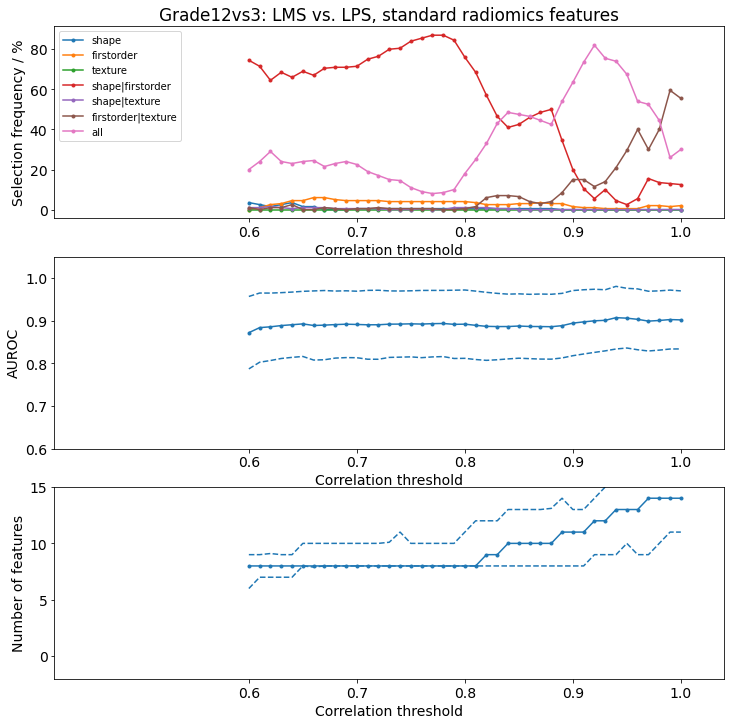

AUROC (CV) = 0.8918

Feature group = shape|firstorder



Feature,Frequency,Coef
lesion_original_firstorder_RootMeanSquared,98.500,-0.175
lesion_original_firstorder_Maximum,98.000,0.623
lesion_original_shape_Sphericity,95.500,-0.443
lesion_original_shape_SurfaceVolumeRatio,95.500,-0.672
lesion_original_shape_Elongation,95.000,-0.235
lesion_original_firstorder_90Percentile,94.000,-1.419
lesion_original_firstorder_Kurtosis,85.500,-0.278
lesion_original_firstorder_InterquartileRange,72.500,0.797
lesion_original_firstorder_Uniformity,24.500,
lesion_original_firstorder_Skewness,21.500,


In [26]:
displayResultExperiments(resultStandardType, titleStr=target + ': LMS vs. LPS, standard radiomics features')
bestCoef, pdFreq = displayOneExperiment(resultStandardType, threshold=0.8)
# bestCoef.style.hide_index()
pdFreq.style.hide_index()

### Tumour type: LMS v.s LPS
### Volume fraction and standard radiomics features

In [9]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'subtype'
featureSet = 'lesion_original|sarcomaFeature'

df = df.filter(regex=featureSet + '|' + target)

In [10]:
settings = {'n_splits':10, 
            'n_repeats':20,
            'thresholds':np.round(np.arange(0.6,1.00001,0.01), 2)}

quickLoadFile = os.path.join(quickLoadFolder, 'LR_GroupSelection_VolumeFractions_TumourType.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

#     with open(quickLoadFile, 'wb') as handle:
#         pickle.dump(result, handle)

resultVolFracType = copy.deepcopy(result)

del result
    

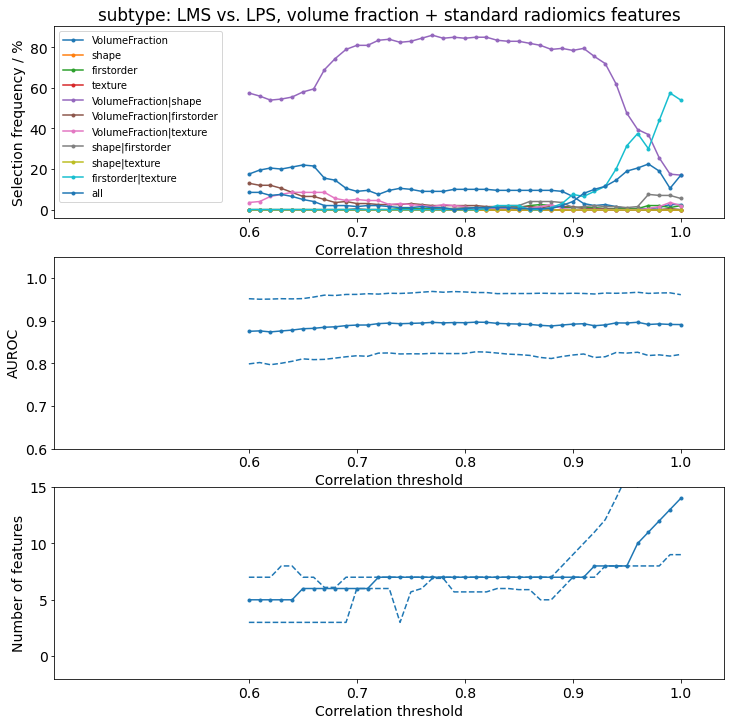

AUROC (CV) = 0.89517

Feature group = VolumeFraction|shape



Feature,Frequency,Coef
lesion_sarcomaFeature_low enhancingVolumeFraction,98.500,20.951
lesion_sarcomaFeature_calcificationVolumeFraction,97.500,0.988
lesion_sarcomaFeature_high enhancingVolumeFraction,97.500,-0.546
lesion_original_shape_Elongation,86.000,-0.952
lesion_original_shape_Sphericity,86.000,-0.745
lesion_original_shape_SurfaceVolumeRatio,86.000,-1.144
lesion_original_shape_Flatness,84.000,0.599
lesion_original_firstorder_90Percentile,4.000,
lesion_original_firstorder_Maximum,4.000,
lesion_original_firstorder_RootMeanSquared,4.000,


In [11]:
displayResultExperiments(resultVolFracType, titleStr = target + ': LMS vs. LPS, volume fraction + standard radiomics features')

bestCoef, pdFreq = displayOneExperiment(resultVolFracType, threshold=0.8)
# bestCoef.style.hide_index()
pdFreq.style.hide_index()

### Tumour grade: 1 v.s 2 or 3
### Standard radiomics features

In [12]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'Grade1vs23'
featureSet = 'lesion_original'

df['Grade1vs23'] = df['Grade'] == 1

df = df.filter(regex=featureSet + '|' + target)

In [13]:
settings = {'n_splits':10, 
            'n_repeats':20,
            'thresholds':np.round(np.arange(0.6,1.00001,0.01), 2)}

textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
settings['groupHierarchy'] = ['shape',
                              'firstorder',
                              textureStr,
                              'shape|firstorder',
                              'shape|' + textureStr,
                              'firstorder|' + textureStr,
                              '']

quickLoadFile = os.path.join(quickLoadFolder, 'LR_GroupSelection_Standard_Grade1vs23.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

#     with open(quickLoadFile, 'wb') as handle:
#         pickle.dump(result, handle)

resultStandardGrade_1vs23 = copy.deepcopy(result)

del result
    

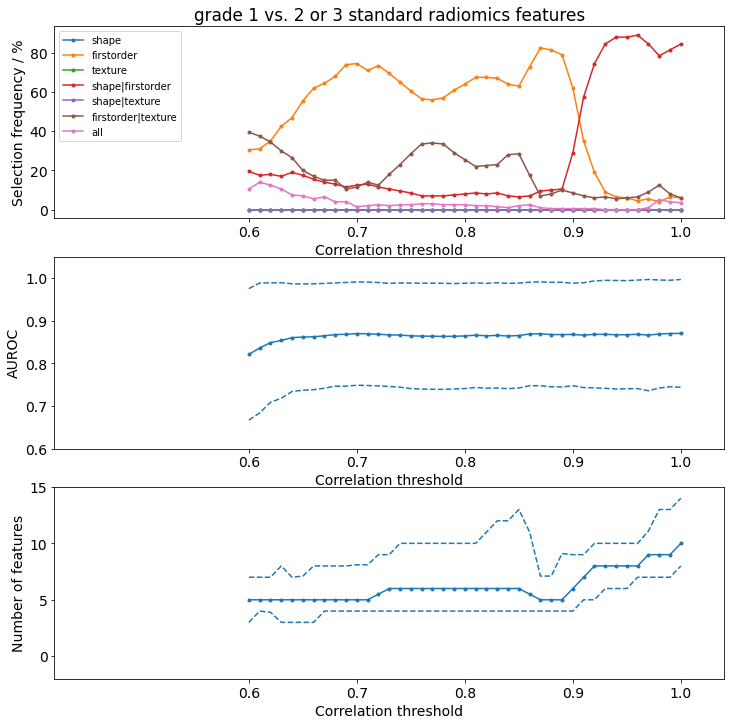

AUROC (CV) = 0.86422

Feature group = firstorder



Feature,Frequency,Coef
lesion_original_firstorder_Minimum,98.500,0.431
lesion_original_firstorder_90Percentile,97.500,-1.693
lesion_original_firstorder_RootMeanSquared,97.000,0.393
lesion_original_firstorder_Maximum,92.000,0.339
lesion_original_firstorder_Skewness,77.500,0.136
lesion_original_glszm_LargeAreaLowGrayLevelEmphasis,28.000,
lesion_original_firstorder_InterquartileRange,26.500,
lesion_original_ngtdm_Strength,21.000,
lesion_original_ngtdm_Contrast,19.500,
lesion_original_firstorder_Kurtosis,16.500,-0.152


In [14]:
displayResultExperiments(resultStandardGrade_1vs23, titleStr = 'grade 1 vs. 2 or 3 standard radiomics features')

bestCoef, pdFreq = displayOneExperiment(resultStandardGrade_1vs23, threshold=0.8)
# bestCoef.style.hide_index()
pdFreq.style.hide_index()

### Tumour grade: 1 or 2 v.s 3
### Standard radiomics features

In [15]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'Grade12vs3'
featureSet = 'lesion_original'

df[target] = df['Grade'] != 3

df = df.filter(regex=featureSet + '|' + target)

In [16]:
settings = {'n_splits':10, 
            'n_repeats':20,
            'thresholds':np.round(np.arange(0.6,1.00001,0.01), 2)}

textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
settings['groupHierarchy'] = ['shape',
                              'firstorder',
                              textureStr,
                              'shape|firstorder',
                              'shape|' + textureStr,
                              'firstorder|' + textureStr,
                              '']

quickLoadFile = os.path.join(quickLoadFolder, 'LR_GroupSelection_Standard_Grade12vs3.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

#     with open(quickLoadFile, 'wb') as handle:
#         pickle.dump(result, handle)

resultStandardGrade_12vs3 = copy.deepcopy(result)

del result
    

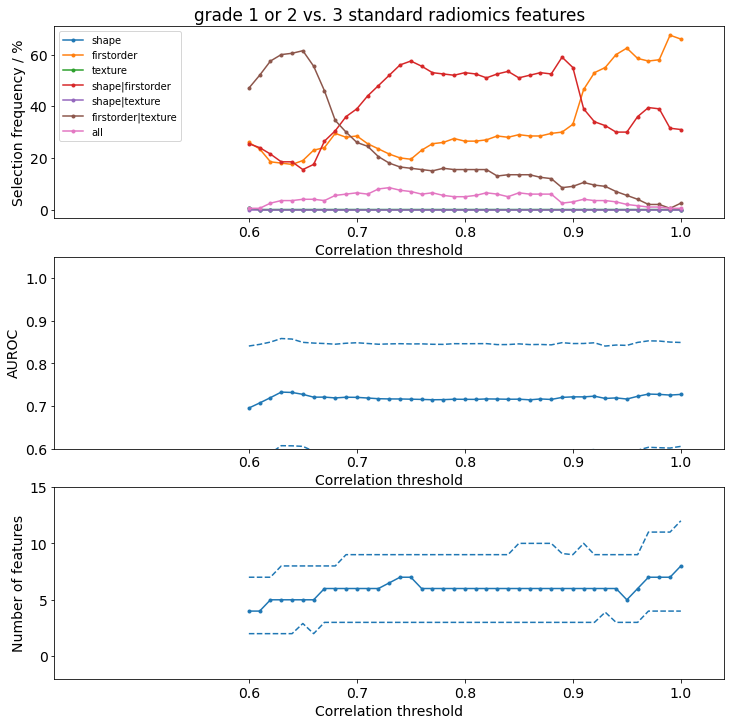

AUROC (CV) = 0.71552

Feature group = shape|firstorder



Feature,Frequency,Coef
lesion_original_firstorder_90Percentile,96.000,-1.209
lesion_original_firstorder_Minimum,89.000,0.159
lesion_original_firstorder_Maximum,82.000,0.189
lesion_original_shape_Flatness,58.000,-0.234
lesion_original_shape_Sphericity,54.000,0.228
lesion_original_shape_SurfaceVolumeRatio,49.500,0.115
lesion_original_firstorder_RootMeanSquared,22.500,
lesion_original_firstorder_InterquartileRange,20.500,
lesion_original_ngtdm_Strength,19.500,
lesion_original_gldm_DependenceNonUniformityNormalized,19.500,


In [17]:
displayResultExperiments(resultStandardGrade_12vs3, titleStr = 'grade 1 or 2 vs. 3 standard radiomics features')

bestCoef, pdFreq = displayOneExperiment(resultStandardGrade_12vs3, threshold=0.8)
# bestCoef.style.hide_index()
pdFreq.style.hide_index()

### Tumour grade: 1 v.s 2 or 3
### Volume fractions and standard radiomics features

In [18]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'Grade1vs23'
featureSet = 'lesion_original|sarcomaFeature'

df['Grade1vs23'] = df['Grade'] == 1

df = df.filter(regex=featureSet + '|' + target)

In [19]:
settings = {'n_splits':10, 
            'n_repeats':20,
            'thresholds':np.round(np.arange(0.6,1.00001,0.01), 2)}

quickLoadFile = os.path.join(quickLoadFolder, 'LR_GroupSelection_VolumeFractions_Grade1vs23.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

#     with open(quickLoadFile, 'wb') as handle:
#         pickle.dump(result, handle)

resultVolumeFractionGrade_1vs23 = copy.deepcopy(result)

del result
    

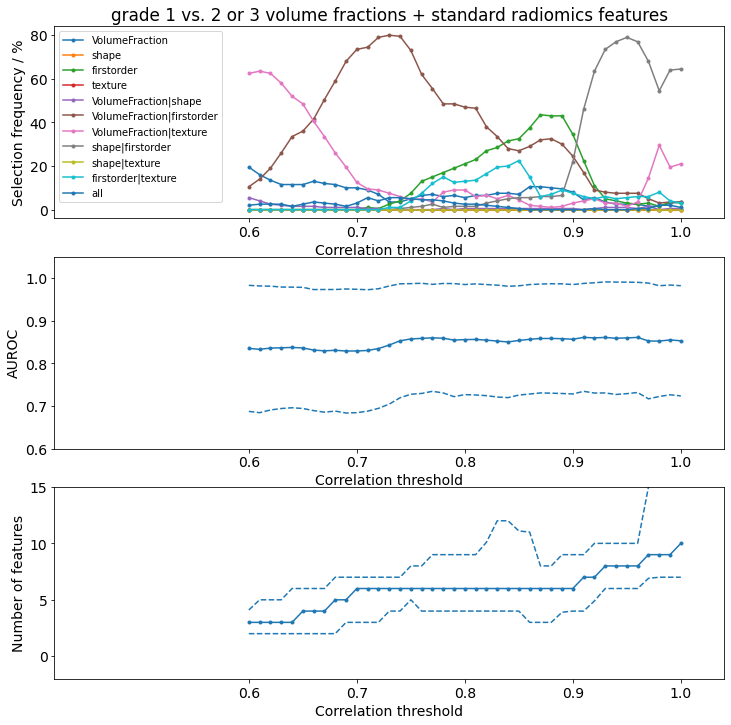

AUROC (CV) = 0.85563

Feature group = VolumeFraction|firstorder



Feature,Frequency,Coef
lesion_original_firstorder_Minimum,84.500,0.312
lesion_original_firstorder_90Percentile,83.500,-1.204
lesion_original_firstorder_Maximum,77.500,0.262
lesion_original_firstorder_RootMeanSquared,77.500,0.216
lesion_sarcomaFeature_low enhancingVolumeFraction,64.500,0.443
lesion_original_firstorder_Skewness,55.000,0.016
lesion_original_firstorder_InterquartileRange,38.000,-0.041
lesion_sarcomaFeature_high enhancingVolumeFraction,34.500,-0.003
lesion_original_glszm_LargeAreaLowGrayLevelEmphasis,23.500,
lesion_original_ngtdm_Contrast,14.000,


In [20]:
displayResultExperiments(resultVolumeFractionGrade_1vs23, titleStr = 'grade 1 vs. 2 or 3 volume fractions + standard radiomics features')

bestCoef, pdFreq = displayOneExperiment(resultVolumeFractionGrade_1vs23, threshold=0.8)
# bestCoef.style.hide_index()
pdFreq.style.hide_index()

### Tumour grade: 1 or 2 v.s 3
### Volume fractions + standard radiomics features 

In [21]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'Grade12vs3'
featureSet = 'lesion_original|sarcomaFeature'

df[target] = df['Grade'] != 3

df = df.filter(regex=featureSet + '|' + target)

In [22]:
settings = {'n_splits':10, 
            'n_repeats':20,
            'thresholds':np.round(np.arange(0.6,1.00001,0.01), 2)}

quickLoadFile = os.path.join(quickLoadFolder, 'LR_GroupSelection_VolumeFractions_Grade12vs3.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

#     with open(quickLoadFile, 'wb') as handle:
#         pickle.dump(result, handle)

resultVolumeFractionGrade_12vs3 = copy.deepcopy(result)

del result
    

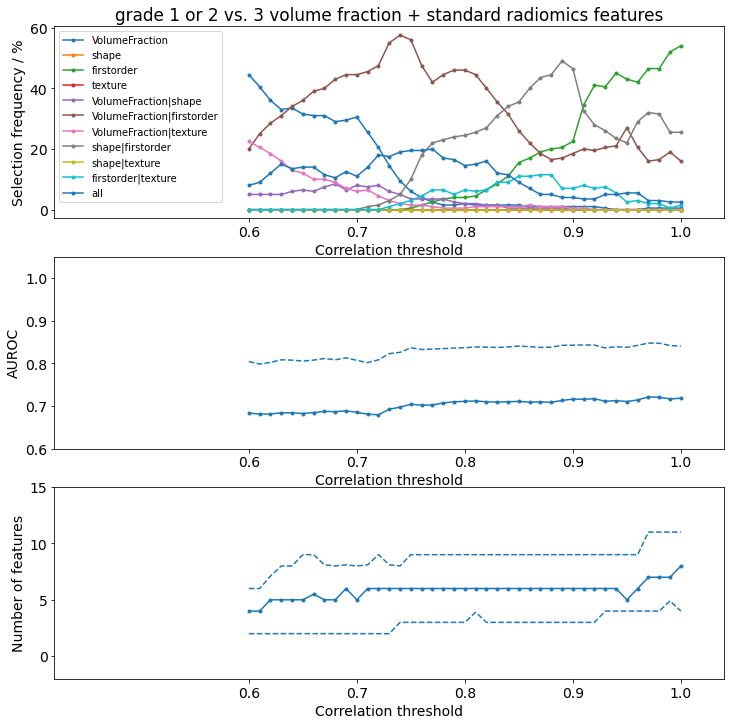

AUROC (CV) = 0.71079

Feature group = VolumeFraction|firstorder



Feature,Frequency,Coef
lesion_original_firstorder_90Percentile,92.000,-0.704
lesion_original_firstorder_Minimum,79.500,0.096
lesion_sarcomaFeature_high enhancingVolumeFraction,64.500,-0.333
lesion_original_firstorder_Maximum,60.000,0.023
lesion_original_shape_Flatness,38.000,
lesion_original_firstorder_InterquartileRange,36.500,-0.033
lesion_original_shape_Sphericity,32.000,
lesion_original_shape_SurfaceVolumeRatio,28.500,
lesion_original_gldm_DependenceNonUniformityNormalized,20.500,
lesion_original_ngtdm_Strength,19.500,


In [23]:
displayResultExperiments(resultVolumeFractionGrade_12vs3, titleStr = 'grade 1 or 2 vs. 3 volume fraction + standard radiomics features')

bestCoef, pdFreq = displayOneExperiment(resultVolumeFractionGrade_12vs3, threshold=0.8)
# bestCoef.style.hide_index()
pdFreq.style.hide_index()